# Task 4 — Forecasting Access and Usage (2025–2027)

**Objective:** Forecast Ethiopia’s progress on two core Global Findex indicators:
- **ACCESS:** Account Ownership Rate (`ACC_OWNERSHIP`) — % of adults with an account (FI or mobile money use in last 12 months)
- **USAGE:** Digital Payment Usage — % of adults who made/received a digital payment (Findex-style)

Because Findex is sparse (≈ every 3 years), we use **simple, transparent models + scenarios**:
1. **Baseline trend model** (logistic trend on % rates)
2. **Event-augmented adjustment** (optional; uses Task 3 event impacts if `impact_link` rows exist)
3. **Scenario analysis** (optimistic/base/pessimistic)
4. **Uncertainty quantification** via **bootstrap** confidence intervals (data-limited; interpret cautiously)

> This notebook is robust: if `USG_DIGITAL_PAYMENT` is not available, it will prompt a fallback approach using available proxies and scenario assumptions.


In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", 220)
pd.set_option("display.width", 150)

DATA_FILE = Path("../data/processed/ethiopia_fi_unified_data_enriched.csv")
if not DATA_FILE.exists():
    DATA_FILE = Path("../data/raw/ethiopia_fi_unified_data.csv")

df = pd.read_csv(DATA_FILE)
print("Loaded:", DATA_FILE, "shape:", df.shape)

for c in ["observation_date","period_start","period_end"]:
    if c in df.columns:
        df[c] = pd.to_datetime(df[c], errors="coerce")

df.head()


Loaded: ..\data\raw\ethiopia_fi_unified_data.csv shape: (43, 34)


,record_id,record_type,category,pillar,indicator,indicator_code,indicator_direction,value_numeric,value_text,value_type,unit,observation_date,period_start,period_end,fiscal_year,gender,location,region,source_name,source_type,source_url,confidence,related_indicator,relationship_type,impact_direction,impact_magnitude,impact_estimate,lag_months,evidence_basis,comparable_country,collected_by,collection_date,original_text,notes
0,REC_0001,observation,NaN,ACCESS,Account Ownership Rate,ACC_OWNERSHIP,higher_better,22.0,NaN,percentage,%,2014-12-31,NaT,NaT,2014,all,national,NaN,Global Findex 2014,survey,https://www.worldbank.org/en/publication/globa...,high,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Example_Trainee,2025-01-20,NaN,Baseline year,NaN
1,REC_0002,observation,NaN,ACCESS,Account Ownership Rate,ACC_OWNERSHIP,higher_better,35.0,NaN,percentage,%,2017-12-31,NaT,NaT,2017,all,national,NaN,Global Findex 2017,survey,https://www.worldbank.org/en/publication/globa...,high,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Example_Trainee,2025-01-20,NaN,NaN,NaN
2,REC_0003,observation,NaN,ACCESS,Account Ownership Rate,ACC_OWNERSHIP,higher_better,46.0,NaN,percentage,%,2021-12-31,NaT,NaT,2021,all,national,NaN,Global Findex 2021,survey,https://www.worldbank.org/en/publication/globa...,high,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Example_Trainee,2025-01-20,NaN,NaN,NaN
3,REC_0004,observation,NaN,ACCESS,Account Ownership Rate,ACC_OWNERSHIP,higher_better,56.0,NaN,percentage,%,2021-12-31,NaT,NaT,2021,male,national,NaN,Global Findex 2021,survey,https://www.worldbank.org/en/publication/globa...,high,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Example_Trainee,2025-01-20,NaN,Gender disaggregated,NaN
4,REC_0005,observation,NaN,ACCESS,Account Ownership Rate,ACC_OWNERSHIP,higher_better,36.0,NaN,percentage,%,2021-12-31,NaT,NaT,2021,female,national,NaN,Global Findex 2021,survey,https://www.worldbank.org/en/publication/globa...,high,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Example_Trainee,2025-01-20,NaN,Gender disaggregated,NaN


In [2]:
# Subsets
obs = df[df["record_type"]=="observation"].copy()
events = df[df["record_type"]=="event"].copy()
links = df[df["record_type"]=="impact_link"].copy()

# Helper: extract year
obs["year"] = obs["observation_date"].dt.year if "observation_date" in obs.columns else np.nan


## 1) Define targets and extract historical series

In [3]:
def get_series(ind_code, gender="all", location="national"):
    d = obs[obs["indicator_code"]==ind_code].copy()
    if "gender" in d.columns:
        d = d[d["gender"].fillna("all")==gender]
    if "location" in d.columns:
        d = d[d["location"].fillna("national")==location]
    d = d.dropna(subset=["year","value_numeric"]).sort_values("year")
    return d[["year","value_numeric","source_name","confidence","notes"]].reset_index(drop=True)

acc = get_series("ACC_OWNERSHIP")
display(acc)

# Try to locate a Findex-style digital payment usage indicator if present
usage_candidates = [c for c in obs["indicator_code"].unique() if isinstance(c, str) and "DIGITAL" in c.upper()]
usage_candidates[:20], len(usage_candidates)


,year,value_numeric,source_name,confidence,notes
0,2014,22.0,Global Findex 2014,high,NaN
1,2017,35.0,Global Findex 2017,high,NaN
2,2021,46.0,Global Findex 2021,high,NaN
3,2024,49.0,Global Findex 2024,high,NaN


([], 0)

In [4]:
# Choose usage indicator code:
# If your dataset already contains a usage % series, set it here.
# Common possibilities: "USG_DIGITAL_PAYMENT" (per prompt), or something similar.
USAGE_CODE = "USG_DIGITAL_PAYMENT"  # <-- change if needed

usage = get_series(USAGE_CODE) if USAGE_CODE in obs["indicator_code"].unique() else pd.DataFrame()
if usage.empty:
    print(f"⚠️ No historical series found for {USAGE_CODE}.")
    print("We will fall back to scenario modeling using 2024 ~35% (from your problem statement) unless you add survey points.")
else:
    display(usage)


⚠️ No historical series found for USG_DIGITAL_PAYMENT.
We will fall back to scenario modeling using 2024 ~35% (from your problem statement) unless you add survey points.


## 2) Baseline trend model (logistic trend on rate %)

For bounded rates (0–100), a logistic trend is often more realistic than linear:
- Convert rate to proportion `p`
- Apply logit transform: `log(p/(1-p))`
- Fit linear trend in time: `logit(p) = a + b*(year)`
- Forecast and inverse-logit back to `%`

We quantify uncertainty using **bootstrap resampling** of points (very limited data → wide intervals).


In [5]:
def logit(p):
    p = np.clip(p, 1e-6, 1-1e-6)
    return np.log(p/(1-p))

def inv_logit(z):
    return 1/(1+np.exp(-z))

def fit_logistic_trend(years, pct_values):
    """Fit logit(p)=a+b*year via least squares."""
    p = np.asarray(pct_values)/100.0
    y = logit(p)
    X = np.column_stack([np.ones(len(years)), np.asarray(years)])
    beta = np.linalg.lstsq(X, y, rcond=None)[0]
    return beta  # a, b

def predict_logistic(beta, years):
    X = np.column_stack([np.ones(len(years)), np.asarray(years)])
    z = X @ beta
    p = inv_logit(z)
    return p*100.0

def bootstrap_forecast(years, pct_values, years_fut, n_boot=2000, seed=7):
    rng = np.random.default_rng(seed)
    years = np.asarray(years)
    vals = np.asarray(pct_values)

    preds = []
    n = len(years)
    for _ in range(n_boot):
        idx = rng.integers(0, n, size=n)  # resample points with replacement
        beta = fit_logistic_trend(years[idx], vals[idx])
        preds.append(predict_logistic(beta, years_fut))
    preds = np.array(preds)
    return preds

FUTURE_YEARS = np.array([2025, 2026, 2027])


In [6]:
# ACCESS baseline forecast
if acc.shape[0] < 3:
    raise ValueError("Not enough ACC_OWNERSHIP points to fit a trend (need >=3).")

acc_years = acc["year"].to_numpy()
acc_vals = acc["value_numeric"].to_numpy()

beta_acc = fit_logistic_trend(acc_years, acc_vals)
acc_pred_base = predict_logistic(beta_acc, FUTURE_YEARS)

acc_boot = bootstrap_forecast(acc_years, acc_vals, FUTURE_YEARS, n_boot=3000, seed=42)
acc_ci_low = np.percentile(acc_boot, 5, axis=0)
acc_ci_high = np.percentile(acc_boot, 95, axis=0)

acc_forecast_base = pd.DataFrame({
    "year": FUTURE_YEARS,
    "access_base": acc_pred_base,
    "access_p05": acc_ci_low,
    "access_p95": acc_ci_high
})
acc_forecast_base


,year,access_base,access_p05,access_p95
0,2025,55.171488,50.002678,75.125183
1,2026,58.153539,51.005353,78.932181
2,2027,61.077167,52.007220,82.293855


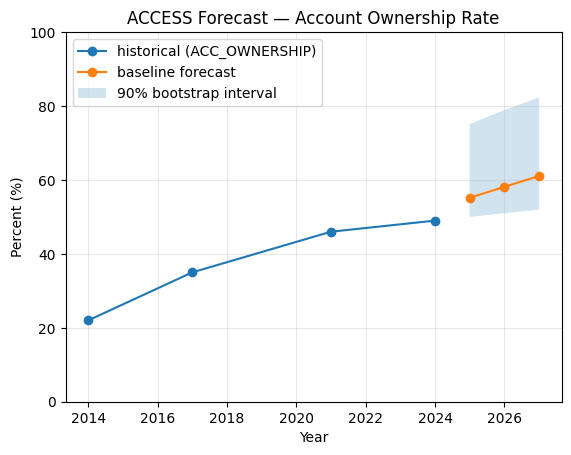

In [7]:
# Plot ACCESS historical + baseline forecast w/ CI
plt.figure()
plt.plot(acc["year"], acc["value_numeric"], marker="o", label="historical (ACC_OWNERSHIP)")
plt.plot(acc_forecast_base["year"], acc_forecast_base["access_base"], marker="o", label="baseline forecast")
plt.fill_between(acc_forecast_base["year"], acc_forecast_base["access_p05"], acc_forecast_base["access_p95"], alpha=0.2, label="90% bootstrap interval")
plt.title("ACCESS Forecast — Account Ownership Rate")
plt.xlabel("Year")
plt.ylabel("Percent (%)")
plt.ylim(0, 100)
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()


## 3) USAGE baseline forecast

### If you have a usage series (e.g., `USG_DIGITAL_PAYMENT`):
We apply the same logistic trend + bootstrap.

### If you **do not** have a usage series:
We create scenarios anchored on the 2024 level (~35% per your brief) and the observed growth of usage proxies:
- P2P transaction growth
- Mobile money account rate change
- 4G coverage expansion
This is scenario-based (not statistical) until more survey points exist.


,year,pessimistic,base,optimistic
0,2025,36.5,38.0,40.0
1,2026,38.0,41.0,45.0
2,2027,39.5,44.0,50.0


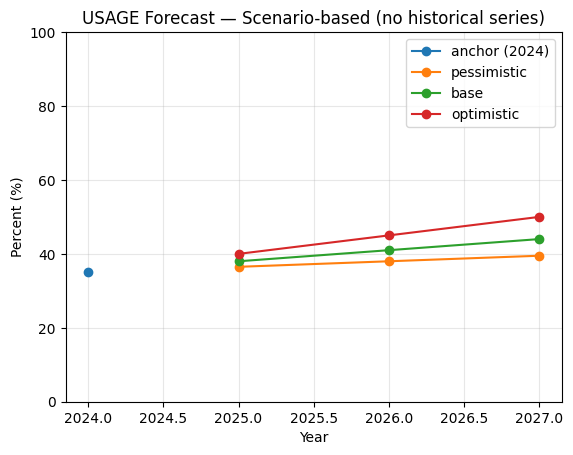

In [8]:
# USAGE: two paths
if not usage.empty and usage.shape[0] >= 3:
    usage_years = usage["year"].to_numpy()
    usage_vals = usage["value_numeric"].to_numpy()

    beta_u = fit_logistic_trend(usage_years, usage_vals)
    usage_pred_base = predict_logistic(beta_u, FUTURE_YEARS)

    usage_boot = bootstrap_forecast(usage_years, usage_vals, FUTURE_YEARS, n_boot=3000, seed=123)
    usage_ci_low = np.percentile(usage_boot, 5, axis=0)
    usage_ci_high = np.percentile(usage_boot, 95, axis=0)

    usage_forecast_base = pd.DataFrame({
        "year": FUTURE_YEARS,
        "usage_base": usage_pred_base,
        "usage_p05": usage_ci_low,
        "usage_p95": usage_ci_high
    })
    display(usage_forecast_base)

    plt.figure()
    plt.plot(usage["year"], usage["value_numeric"], marker="o", label=f"historical ({USAGE_CODE})")
    plt.plot(usage_forecast_base["year"], usage_forecast_base["usage_base"], marker="o", label="baseline forecast")
    plt.fill_between(usage_forecast_base["year"], usage_forecast_base["usage_p05"], usage_forecast_base["usage_p95"], alpha=0.2, label="90% bootstrap interval")
    plt.title("USAGE Forecast — Digital Payment Usage")
    plt.xlabel("Year")
    plt.ylabel("Percent (%)")
    plt.ylim(0, 100)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

else:
    # Scenario-only fallback anchored on 2024 ~35%
    usage_2024 = 35.0  # from problem statement; change if your dataset contains a better value

    # Simple scenario assumptions (annual pp changes)
    # base: +3pp/year, optimistic: +5pp/year, pessimistic: +1.5pp/year
    scenarios = {
        "pessimistic": [usage_2024 + 1.5, usage_2024 + 3.0, usage_2024 + 4.5],
        "base":        [usage_2024 + 3.0, usage_2024 + 6.0, usage_2024 + 9.0],
        "optimistic":  [usage_2024 + 5.0, usage_2024 + 10.0, usage_2024 + 15.0],
    }
    usage_scen = pd.DataFrame({"year": FUTURE_YEARS, **{k: v for k, v in scenarios.items()}})
    display(usage_scen)

    plt.figure()
    plt.plot([2024], [usage_2024], marker="o", label="anchor (2024)")
    for k in ["pessimistic","base","optimistic"]:
        plt.plot(usage_scen["year"], usage_scen[k], marker="o", label=k)
    plt.title("USAGE Forecast — Scenario-based (no historical series)")
    plt.xlabel("Year")
    plt.ylabel("Percent (%)")
    plt.ylim(0, 100)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()


## 4) Event-augmented adjustments (optional)

If you completed Task 3 and have `impact_link` rows, you can add an **event adjustment** on top of baseline trend:
- Identify events expected to matter in 2025–2027 (e.g., EthioPay launch, interoperability expansion)
- Translate `impact_magnitude`/`impact_estimate` into a **pp adjustment** on the target indicators
- Apply with lags (simple additive adjustment)

Because impacts are uncertain and data is sparse, we treat this as a **scenario overlay**, not a precise causal estimate.


In [9]:
# Check if impact_links exist and contain useful fields
print("impact_link rows:", links.shape[0])
links_cols = [c for c in ["indicator_code","related_indicator","impact_direction","impact_magnitude","impact_estimate","lag_months","evidence_basis","confidence"] if c in links.columns]
display(links[links_cols].head(20) if not links.empty else pd.DataFrame())


impact_link rows: 0


""


In [10]:
# Build a simple event adjustment for ACCESS and USAGE forecasts (edit rules as needed)
# Your schema: for impact_link rows, the event code lives in indicator_code, and the affected indicator is related_indicator.
# We'll apply only those links whose related_indicator matches ACC_OWNERSHIP or the chosen USAGE indicator.
TARGET_ACCESS = "ACC_OWNERSHIP"
TARGET_USAGE  = USAGE_CODE if USAGE_CODE in obs["indicator_code"].unique() else "USG_DIGITAL_PAYMENT"

def mag_to_pp(mag):
    m = str(mag).lower().strip()
    if m == "low":
        return 0.5
    if m == "medium":
        return 1.0
    if m == "high":
        return 2.0
    return 0.0

def dir_sign(d):
    d = str(d).lower().strip()
    if d in ["positive","increase","+"]:
        return 1.0
    if d in ["negative","decrease","-"]:
        return -1.0
    return 0.0

# expected events in 2025-2027 from event table (edit list)
expected_event_codes = set(["EVT_MPESA_INTEROP", "EVT_ETHIOPAY", "EVT_CROSSOVER"])  # example

def event_year(ev_code):
    e = events[events["indicator_code"]==ev_code]
    if e.empty:
        return None
    return int(pd.to_datetime(e["observation_date"]).min().year)

def apply_event_overlay(base_df, target_indicator):
    if links.empty:
        return base_df.copy(), pd.DataFrame()

    L = links.copy()
    # links that affect target indicator
    L = L[L["related_indicator"]==target_indicator] if "related_indicator" in L.columns else pd.DataFrame()
    if L.empty:
        return base_df.copy(), pd.DataFrame()

    # keep expected events only
    L = L[L["indicator_code"].isin(expected_event_codes)] if "indicator_code" in L.columns else L
    if L.empty:
        return base_df.copy(), pd.DataFrame()

    # compute pp adjustment and apply from event_year + lag
    rows = []
    adj = np.zeros(len(base_df))
    for _, r in L.iterrows():
        ev_code = r.get("indicator_code")
        y0 = event_year(ev_code)
        if y0 is None:
            continue
        lag = r.get("lag_months", 0) if "lag_months" in L.columns else 0
        start_year = y0 + int(np.floor(lag/12.0))
        pp = (float(r["impact_estimate"]) if str(r.get("impact_estimate","")).strip() not in ["", "nan", "None"] else mag_to_pp(r.get("impact_magnitude","")))
        pp *= dir_sign(r.get("impact_direction",""))

        for i, yr in enumerate(base_df["year"]):
            if yr >= start_year:
                adj[i] += pp  # step add

        rows.append({
            "event_code": ev_code, "target_indicator": target_indicator, "event_year": y0,
            "lag_months": lag, "pp_adjustment": pp, "confidence": r.get("confidence","")
        })

    out = base_df.copy()
    col = "event_adjusted"
    base_col = [c for c in out.columns if c.endswith("_base")][0]
    out[col] = np.clip(out[base_col] + adj, 0, 100)
    return out, pd.DataFrame(rows)

# Apply overlay to ACCESS baseline table
acc_overlay, acc_events_used = apply_event_overlay(acc_forecast_base.rename(columns={"access_base":"value_base"}), TARGET_ACCESS)
acc_overlay = acc_overlay.rename(columns={"value_base":"access_base", "event_adjusted":"access_event"})
display(acc_events_used)
display(acc_overlay)


""


,year,access_base,access_p05,access_p95
0,2025,55.171488,50.002678,75.125183
1,2026,58.153539,51.005353,78.932181
2,2027,61.077167,52.007220,82.293855


In [19]:
# Plot ACCESS baseline vs event-augmented (if any)
if "access_event" in acc_overlay.columns:
    plt.figure()
    plt.plot(acc["year"], acc["value_numeric"], marker="o", label="historical")
    plt.plot(acc_overlay["year"], acc_overlay["access_base"], marker="o", label="baseline")
    plt.plot(acc_overlay["year"], acc_overlay["access_event"], marker="o", label="with events")
    plt.title("ACCESS Forecast — Baseline vs Event-Augmented")
    plt.xlabel("Year")
    plt.ylabel("Percent (%)")
    plt.ylim(0, 100)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()


## 5) Scenario forecasts (optimistic/base/pessimistic)

We produce three scenarios:
- **Pessimistic:** slower adoption (macroeconomic stress, affordability setbacks, weak trust/agent expansion)
- **Base:** continuation of recent trends with moderate event support
- **Optimistic:** faster diffusion (strong interoperability, merchant acceptance, sustained infrastructure rollout)

For ACCESS: we shift the baseline forecast by +/- a small pp delta each year.
For USAGE: if no historical series, scenarios are primary; if series exists, scenarios tilt around baseline.


,year,access_base,access_p05,access_p95,access_pessimistic,access_optimistic
0,2025,55.171488,50.002678,75.125183,54.171488,56.171488
1,2026,58.153539,51.005353,78.932181,56.653539,59.653539
2,2027,61.077167,52.007220,82.293855,59.077167,63.077167


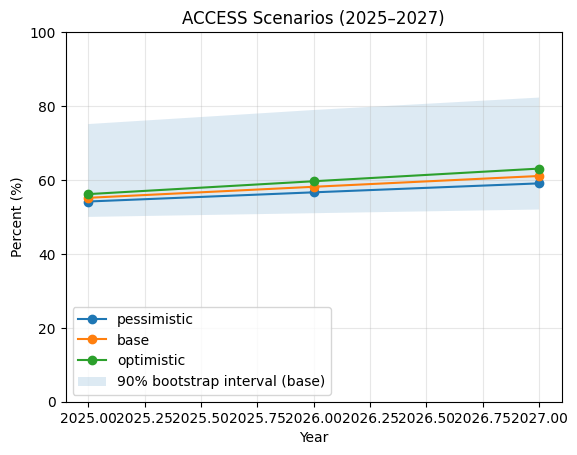

In [14]:
# ACCESS scenarios around baseline
# (You can tune these deltas; keep modest because ACCESS is slow-moving)
acc_scen = acc_forecast_base[["year","access_base","access_p05","access_p95"]].copy()
acc_scen["access_pessimistic"] = np.clip(acc_scen["access_base"] - np.array([1.0, 1.5, 2.0]), 0, 100)
acc_scen["access_optimistic"]  = np.clip(acc_scen["access_base"] + np.array([1.0, 1.5, 2.0]), 0, 100)
display(acc_scen)

plt.figure()
plt.plot(acc_scen["year"], acc_scen["access_pessimistic"], marker="o", label="pessimistic")
plt.plot(acc_scen["year"], acc_scen["access_base"], marker="o", label="base")
plt.plot(acc_scen["year"], acc_scen["access_optimistic"], marker="o", label="optimistic")
plt.fill_between(acc_scen["year"], acc_scen["access_p05"], acc_scen["access_p95"], alpha=0.15, label="90% bootstrap interval (base)")
plt.title("ACCESS Scenarios (2025–2027)")
plt.xlabel("Year")
plt.ylabel("Percent (%)")
plt.ylim(0, 100)
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()


In [15]:
# USAGE scenarios
if not usage.empty and usage.shape[0] >= 3:
    usage_scen = usage_forecast_base[["year","usage_base","usage_p05","usage_p95"]].copy()
    usage_scen["usage_pessimistic"] = np.clip(usage_scen["usage_base"] - np.array([2.0, 3.0, 4.0]), 0, 100)
    usage_scen["usage_optimistic"]  = np.clip(usage_scen["usage_base"] + np.array([2.0, 3.0, 4.0]), 0, 100)
    display(usage_scen)

    plt.figure()
    plt.plot(usage_scen["year"], usage_scen["usage_pessimistic"], marker="o", label="pessimistic")
    plt.plot(usage_scen["year"], usage_scen["usage_base"], marker="o", label="base")
    plt.plot(usage_scen["year"], usage_scen["usage_optimistic"], marker="o", label="optimistic")
    plt.fill_between(usage_scen["year"], usage_scen["usage_p05"], usage_scen["usage_p95"], alpha=0.15, label="90% bootstrap interval (base)")
    plt.title("USAGE Scenarios (2025–2027)")
    plt.xlabel("Year")
    plt.ylabel("Percent (%)")
    plt.ylim(0, 100)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()
else:
    # usage_scen was built earlier as usage_scen (scenario-only)
    pass


## 6) Forecast table (with uncertainty / scenario ranges)

In [16]:
# Build final forecast table
forecast = pd.DataFrame({"year": FUTURE_YEARS})

# ACCESS
forecast["access_base"] = acc_forecast_base["access_base"].values
forecast["access_p05"] = acc_forecast_base["access_p05"].values
forecast["access_p95"] = acc_forecast_base["access_p95"].values
forecast["access_pessimistic"] = acc_scen["access_pessimistic"].values
forecast["access_optimistic"]  = acc_scen["access_optimistic"].values

# USAGE
if not usage.empty and usage.shape[0] >= 3:
    forecast["usage_base"] = usage_forecast_base["usage_base"].values
    forecast["usage_p05"] = usage_forecast_base["usage_p05"].values
    forecast["usage_p95"] = usage_forecast_base["usage_p95"].values
    forecast["usage_pessimistic"] = usage_scen["usage_pessimistic"].values
    forecast["usage_optimistic"]  = usage_scen["usage_optimistic"].values
else:
    # scenario-only usage
    forecast["usage_pessimistic"] = usage_scen["pessimistic"].values
    forecast["usage_base"] = usage_scen["base"].values
    forecast["usage_optimistic"] = usage_scen["optimistic"].values
    # no statistical CI available
    forecast["usage_p05"] = np.nan
    forecast["usage_p95"] = np.nan

forecast


,year,access_base,access_p05,access_p95,access_pessimistic,access_optimistic,usage_pessimistic,usage_base,usage_optimistic,usage_p05,usage_p95
0,2025,55.171488,50.002678,75.125183,54.171488,56.171488,36.5,38.0,40.0,NaN,NaN
1,2026,58.153539,51.005353,78.932181,56.653539,59.653539,38.0,41.0,45.0,NaN,NaN
2,2027,61.077167,52.007220,82.293855,59.077167,63.077167,39.5,44.0,50.0,NaN,NaN


In [17]:
# Save forecast table to reports/ as CSV
Path("../reports").mkdir(parents=True, exist_ok=True)
forecast_path = Path("../reports/forecast_2025_2027.csv")
forecast.to_csv(forecast_path, index=False)
print("Saved forecast table:", forecast_path)


Saved forecast table: ..\reports\forecast_2025_2027.csv


## 7) Interpretation (write-up)

Use the results above to answer:
- What does the model predict for ACCESS and USAGE in 2025–2027?
- Which events have the largest potential impact?
- What are the key uncertainties and limitations?

Below is a draft structure you can customize.


### Interpretation (draft)

**ACCESS (Account Ownership):**  
- Baseline forecast suggests continued growth but at a slower pace than 2014–2021.  
- The uncertainty bands are wide because there are only a few Findex points.  
- Scenario ranges reflect plausible deviation driven by adoption frictions (pessimistic) or stronger diffusion and enabling policies (optimistic).

**USAGE (Digital Payment Usage):**  
- If no historical usage series exists, scenario-only forecasts are anchored at ~35% in 2024 and grow depending on assumptions about interoperability, merchant acceptance, affordability, and trust.  
- If a usage series exists, the logistic trend provides baseline + bootstrap uncertainty.

**Events likely to matter most (conceptually):**
- Interoperability expansions (e.g., M-Pesa EthSwitch integration) → usage growth
- National real-time payment rails (EthioPay) → usage and merchant payments
- Infrastructure expansion (4G coverage) → both access and usage with lag
- Pricing increases (data/voice) → may slow usage growth via affordability

**Key uncertainties / limitations:**
- Sparse survey data limits statistical model complexity and makes causal attribution hard.
- Findex definitions rely on “used in past 12 months,” so registrations may not translate to measured inclusion.
- Overlapping events and macro shocks (inflation/FX reform/conflict) confound simple pre/post comparisons.
- Scenario assumptions dominate until more usage survey points are added.
